# Development

All code here is experimental. Please see README for current usage instructions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
)
from forecastiso.forecasters import SimpleXGBForecaster, WindowedXGBForecaster

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [3]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2022-01-01 00:00:00,caiso,22303.67
1,2022-01-01 01:00:00,caiso,21491.08
2,2022-01-01 02:00:00,caiso,21041.72
3,2022-01-01 03:00:00,caiso,20875.96
4,2022-01-01 04:00:00,caiso,20901.42


In [4]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

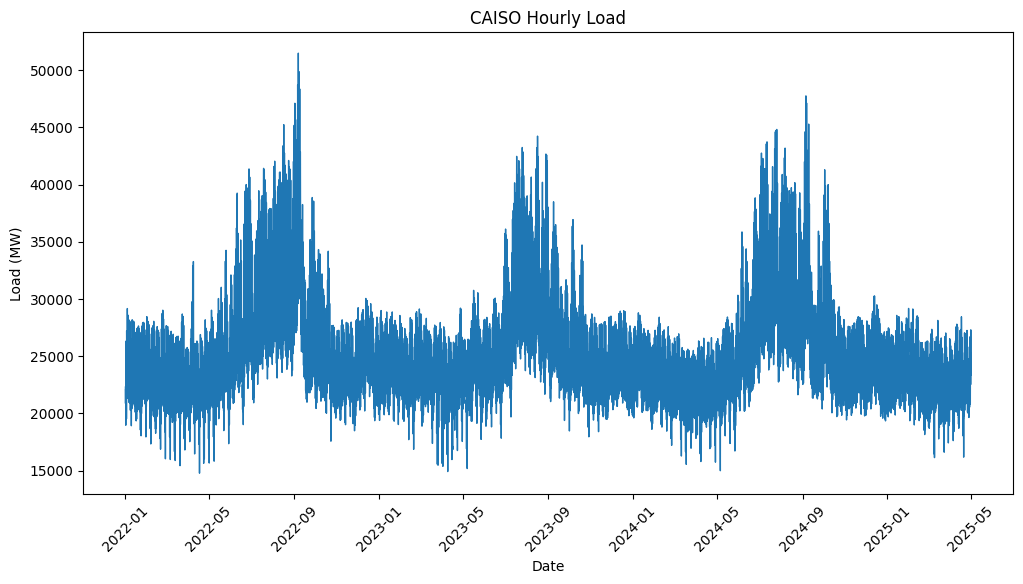

In [5]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=1)
plt.title("CAISO Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [6]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-12"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index(drop=True)

In [7]:
df_filtered.tail()

,datetime,load
27307,2025-02-11 19:00:00,27952.399986
27308,2025-02-11 20:00:00,27377.637563
27309,2025-02-11 21:00:00,26548.832918
27310,2025-02-11 22:00:00,25033.677535
27311,2025-02-11 23:00:00,23393.151125


In [13]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
# fm.add_generator(InteractionFeatureGenerator([["hour", "day_before_weekend"]]))

features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
print(features_df.dtypes)

(27144, 28)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dow', 'month', 'day', 'quarter', 'year', 'doy', 'is_weekend',
       'day_before_weekend', 'is_holiday', 'day_before_holiday',
       'day_after_holiday'],
      dtype='object')
load                     float64
load_lag_24              float64
load_lag_48              float64
load_lag_168             float64
load_rolling_mean_24     float64
load_rolling_std_24      float64
load_rolling_min_24      float64
load_rolling_max_24      float64
load_rolling_mean_168    float64
load_rolling_std_168     float64
load_rolling_min_168     float64
load_rolling_max_168     float64
load_rolling_mean_720 

In [9]:
# forecaster = LinearRegressionForecaster(
#     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
#                   "load_rolling_mean_24", "load_rolling_mean_168", "load_rolling_mean_720",
#                   "hour", "month", "dayofweek", "is_weekend", "day", "quarter", "hour_is_weekend"],
#     target_col="load",
#     standardize=False,
#     # use_ridge=True,
#     # alpha=1.0,
# )

# forecaster.fit(features_df)

# prediction = forecaster.predict(horizon=24)


In [10]:
# prediction

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(ground_truth, label="Ground Truth", linewidth=1)
# plt.plot(prediction, label="Prediction", linewidth=1)
# plt.legend()
# plt.show()

In [14]:
simple_xgb = SimpleXGBForecaster(
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                 "hour", "month", "dow", "doy", "is_holiday", "day_before_holiday", "day_before_weekend", 
                 "day", "quarter", "year"],
    target_col="load",
    # n_estimators=300,
    max_depth=6,
)

simple_xgb.fit(features_df)
prediction = simple_xgb.predict(horizon=24)

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(ground_truth, label="Ground Truth", linewidth=1)
# plt.plot(prediction, label="Prediction", linewidth=1)
# plt.legend()
# plt.show()

In [15]:
mape = mean_absolute_percentage_error(ground_truth, prediction)
mae = mean_absolute_error(ground_truth, prediction)
rmse = root_mean_squared_error(ground_truth, prediction)

print(mape)
print(mae)
print(rmse)

0.0451319470813423
1189.0934971874954
1429.0178870412


In [23]:
windowed_xgb = WindowedXGBForecaster(
    target_col="load",
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                   "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                   "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                   "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                   "hour", "month", "dow", "doy", "is_holiday", "day_before_holiday", "day_before_weekend", 
                   "day", "quarter", "year"],
    max_depth=6,
)

windowed_xgb.fit(features_df)
prediction = windowed_xgb.predict(horizon=24)

In [8]:
# plt.figure(figsize=(12, 6))
# plt.plot(ground_truth, label="Ground Truth", linewidth=1)
# plt.plot(prediction, label="Prediction", linewidth=1)
# plt.legend()
# plt.show()

In [21]:
mape = mean_absolute_percentage_error(prediction, ground_truth)
mae = mean_absolute_error(prediction, ground_truth)
rmse = root_mean_squared_error(prediction, ground_truth)

print(mape)
print(mae)
print(rmse)

0.08877015074772515
2093.5823480989534
2562.1138957322287


In [18]:
features_df = fm.generate_features(df)

Fitting and evaluating model for 2025-02-12 00:00:00
Predicting for 2025-02-12 00:00:00 with latest row at 2025-02-11 23:00:00


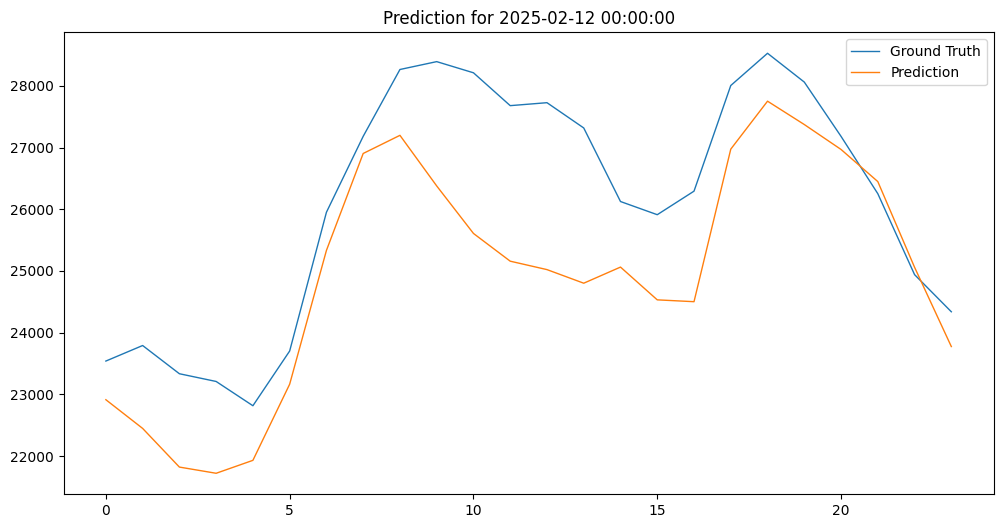

MAPE for 2025-02-12 00:00:00: 0.04821938105408905
MAE for 2025-02-12 00:00:00: 1189.0934971874954
RMSE for 2025-02-12 00:00:00: 1429.0178870412


Fitting and evaluating model for 2025-02-13 00:00:00
Predicting for 2025-02-13 00:00:00 with latest row at 2025-02-12 23:00:00


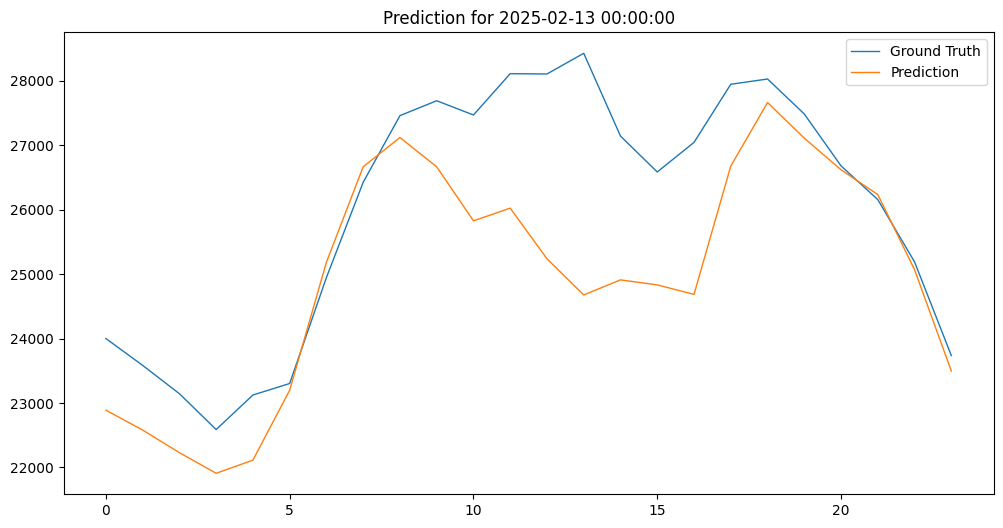

MAPE for 2025-02-13 00:00:00: 0.04353129525415084
MAE for 2025-02-13 00:00:00: 1077.7434292083167
RMSE for 2025-02-13 00:00:00: 1454.4231409244298


Fitting and evaluating model for 2025-02-14 00:00:00
Predicting for 2025-02-14 00:00:00 with latest row at 2025-02-13 23:00:00


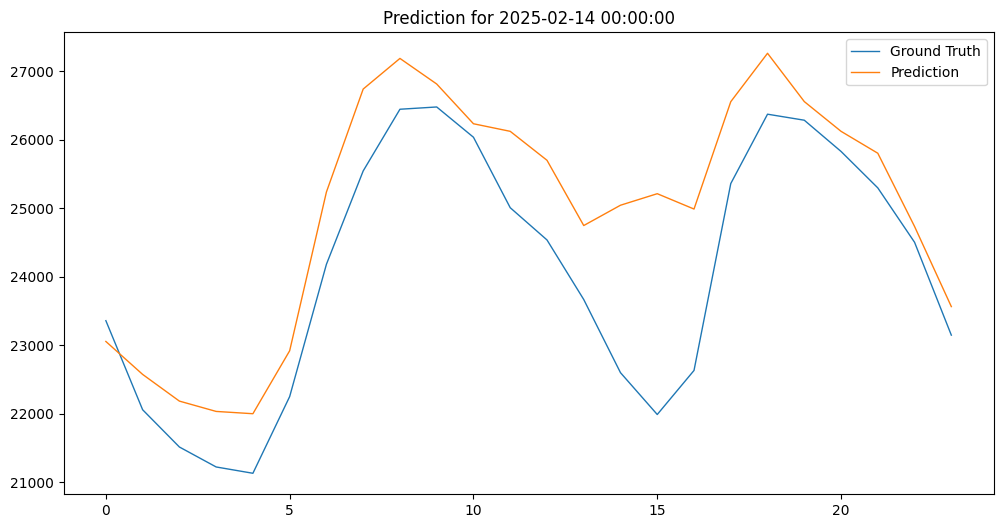

MAPE for 2025-02-14 00:00:00: 0.03757990762941197
MAE for 2025-02-14 00:00:00: 938.844449627096
RMSE for 2025-02-14 00:00:00: 1197.270025805029


Fitting and evaluating model for 2025-02-15 00:00:00
Predicting for 2025-02-15 00:00:00 with latest row at 2025-02-14 23:00:00


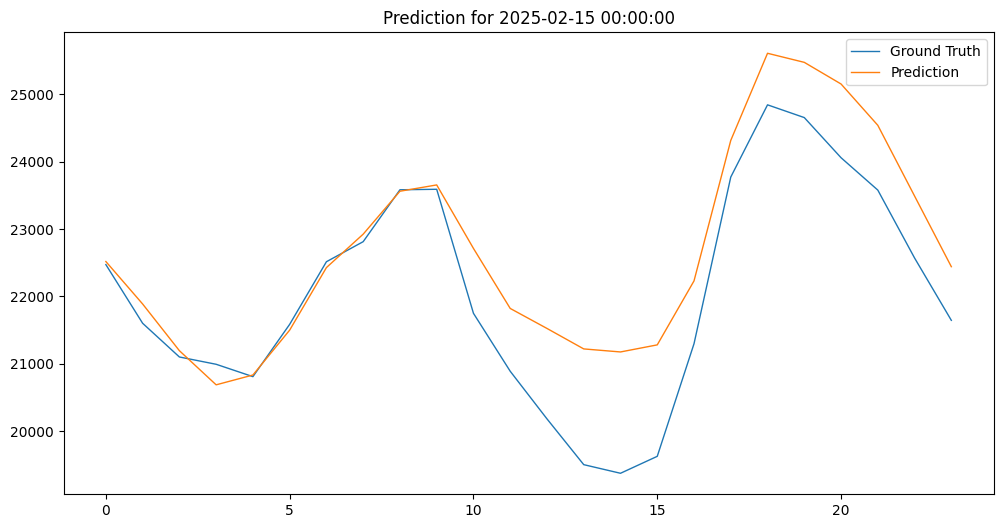

MAPE for 2025-02-15 00:00:00: 0.030298973954435714
MAE for 2025-02-15 00:00:00: 682.4482826062585
RMSE for 2025-02-15 00:00:00: 884.933451880801


Fitting and evaluating model for 2025-02-16 00:00:00
Predicting for 2025-02-16 00:00:00 with latest row at 2025-02-15 23:00:00


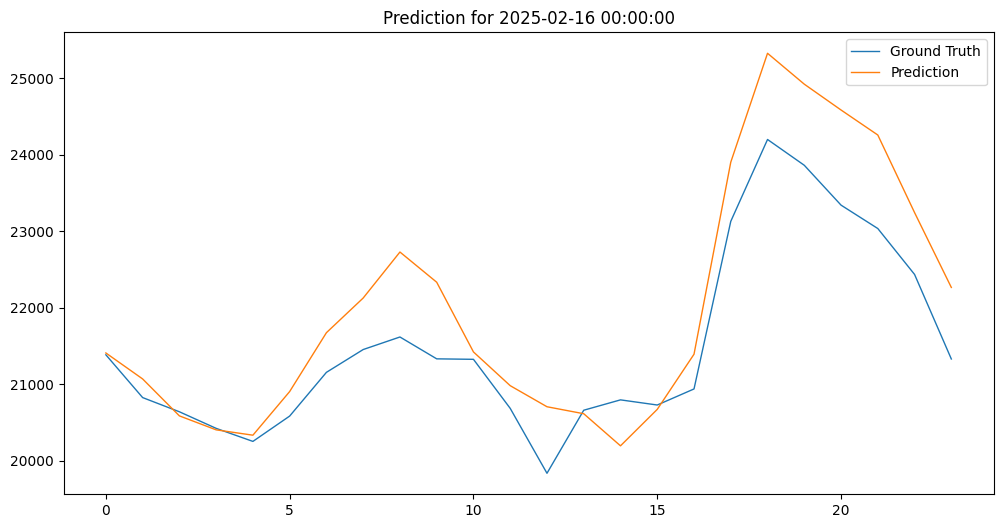

MAPE for 2025-02-16 00:00:00: 0.0249021792350482
MAE for 2025-02-16 00:00:00: 568.4983970322957
RMSE for 2025-02-16 00:00:00: 710.9447185511258


Fitting and evaluating model for 2025-02-17 00:00:00
Predicting for 2025-02-17 00:00:00 with latest row at 2025-02-16 23:00:00


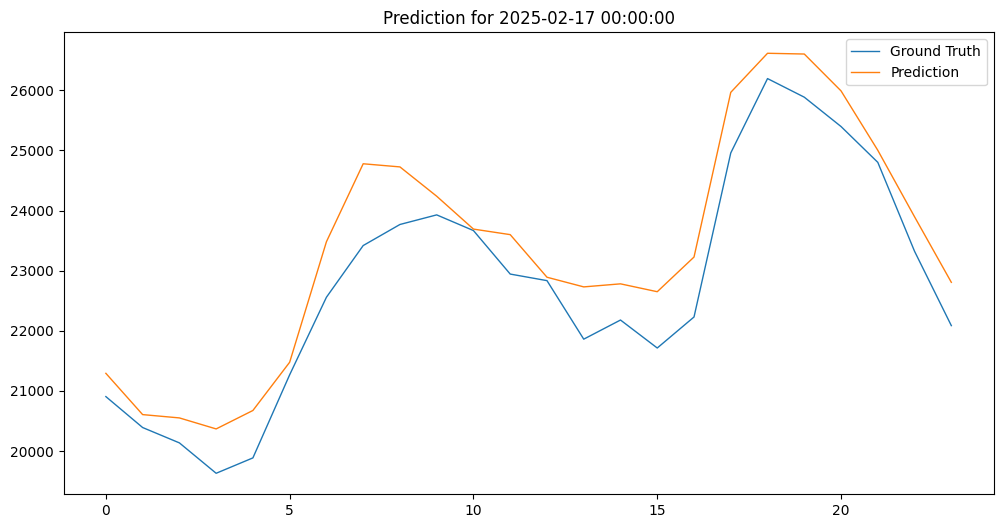

MAPE for 2025-02-17 00:00:00: 0.02613026620533213
MAE for 2025-02-17 00:00:00: 611.8360626437669
RMSE for 2025-02-17 00:00:00: 697.3708209044711


Fitting and evaluating model for 2025-02-18 00:00:00
Predicting for 2025-02-18 00:00:00 with latest row at 2025-02-17 23:00:00


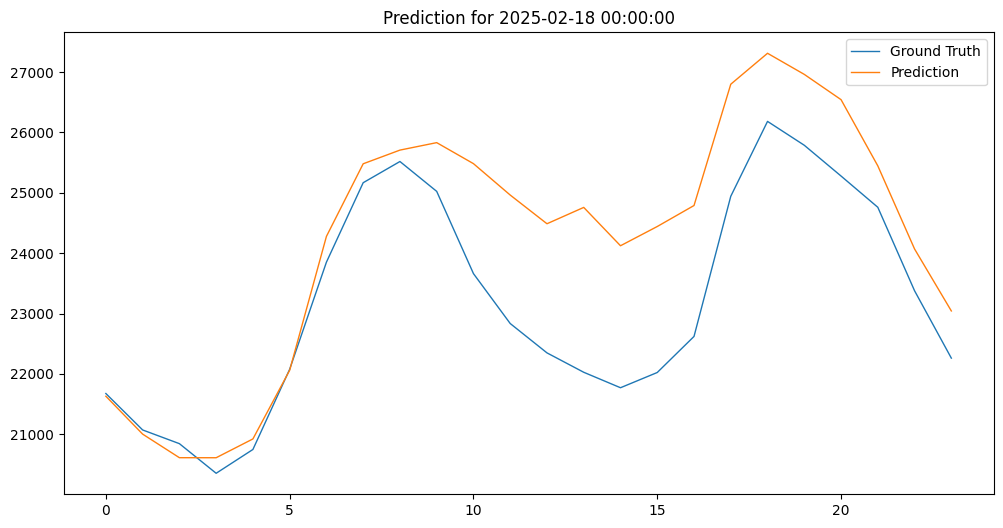

MAPE for 2025-02-18 00:00:00: 0.04317615859864674
MAE for 2025-02-18 00:00:00: 1077.832707115629
RMSE for 2025-02-18 00:00:00: 1389.3376370801511




In [ ]:
# evaluate predictions and plot for 7 days
for i in range(7):

    # at 00:00 hours
    cur_predict_date = pd.to_datetime(predict_date) + pd.Timedelta(days=i)
    cur_day_before_date = pd.to_datetime(predict_date) + pd.Timedelta(days=i-1)

    # data for the day we are predicting
    predict_df = features_df[cur_predict_date:cur_predict_date + pd.Timedelta(hours=23)]
    y_true = predict_df["load"].reset_index(drop=True)
    # print(y_true.tail())
    # print(y_true.shape)

    # filter by predict_date using datetime index
    print(f"Fitting and evaluating model for {cur_predict_date}")

    # simple_xgb = SimpleXGBForecaster(
    #     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
    #                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
    #                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
    #                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
    #                 "hour", "month", "dayofweek", "dayofyear", "is_holiday", "day_before_holiday", "is_weekend", 
    #                 "day", "quarter", "year", "hour_is_weekend"],
    #     target_col="load",
    #     # n_estimators=300,
    #     max_depth=6,
    # )
    # simple_xgb.fit(cur_features_df)
    # predict_features_df = fm.generate_features(predict_df)

    # take latest row as pandas series and df for windowed version
    day_before_df = features_df[cur_day_before_date:cur_day_before_date + pd.Timedelta(hours=23)]
    latest_row = day_before_df.iloc[-1]
    latest_datetime = day_before_df.index[-1]
    latest_day_df = day_before_df[latest_datetime - pd.Timedelta(hours=23):latest_datetime]
    # print(latest_day_df.shape)
    # print(latest_day_df.head().index)

    # check temporal alignment
    print(f"Predicting for {cur_predict_date} with latest row at {latest_datetime}")
    
    # inference
    # y_pred = simple_xgb.predict(horizon=24, external_features=latest_row)
    y_pred = windowed_xgb.predict(horizon=24, external_data=latest_day_df)

    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Ground Truth", linewidth=1)
    plt.plot(y_pred, label="Prediction", linewidth=1)
    plt.title(f"Prediction for {cur_predict_date}")
    plt.legend()
    plt.show()

    mape = mean_absolute_percentage_error(y_pred, y_true)
    mae = mean_absolute_error(y_pred, y_true)
    rmse = root_mean_squared_error(y_pred, y_true)

    print(f"MAPE for {cur_predict_date}: {mape}")
    print(f"MAE for {cur_predict_date}: {mae}")
    print(f"RMSE for {cur_predict_date}: {rmse}")
    print("\n")